# Advanced Lane Finding

## Image Calibration

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from moviepy.editor import VideoFileClip, ImageSequenceClip
from IPython.display import HTML

sample_image = cv2.imread("camera_cal/calibration3.jpg")

def showBeforeVsAfter(before, after, before_caption="Before", after_caption="After"):
    """
    Displays two images side by side
    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor(before, cv2.COLOR_BGR2RGB))
    ax1.set_title(before_caption, fontsize=50)
    ax2.imshow(cv2.cvtColor(after, cv2.COLOR_BGR2RGB))
    ax2.set_title(after_caption, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return
    

### Get Corners

In [3]:
def drawCorners(image, nx=9, ny=6):
    """ 
    :param image: A chassboard image to get corners from
    :param nx: The number of horizontal corners in the image
    :param ny: The number of vertical corners in the image
    
    :return: objp, corners, image overlayed with corners
    """

    #prepare object points
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, add object points, image points and draw corners
    if ret == True:
        # Draw the corners unto the image
        overlayed_image = np.copy(image)
        cv2.drawChessboardCorners(overlayed_image, (nx, ny), corners, ret)
        return ret, objp, corners, overlayed_image
    return ret, None, None, None

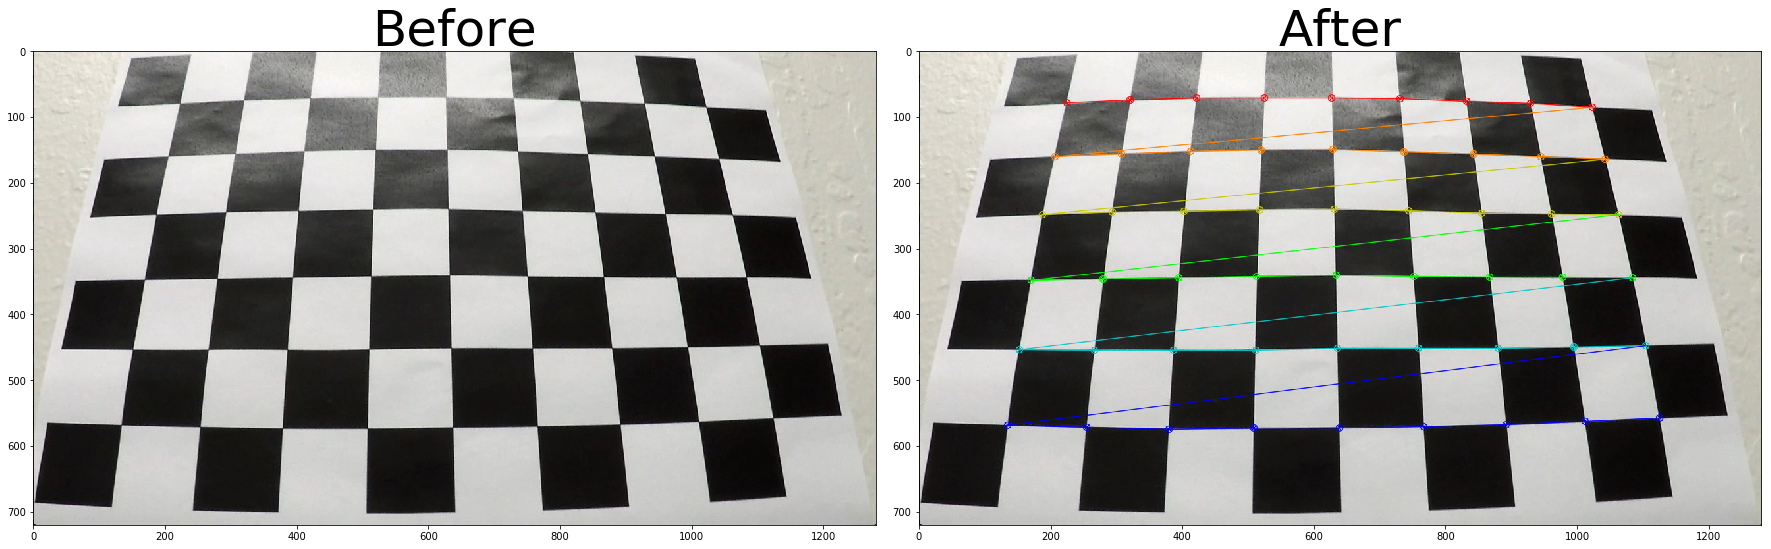

In [4]:
# Exploration
showBeforeVsAfter(sample_image, drawCorners(sample_image)[3])

### Calibrate Camera

In [5]:
def calibrate_camera(image_shape, object_points, image_points):
    
    # Calibrate camera based on all object and image points.
    ret, matrix, distortion, rvecs, tvecs = cv2.calibrateCamera(object_points,image_points,image_shape,None,None)
    return matrix,distortion

In [6]:
object_points = [] 
image_points = []

for image_path in glob.glob("camera_cal/*.jpg"):
    image = cv2.imread(image_path)
    ret, objp, corners, higlighted_image = drawCorners(image)
    if ret:
        object_points.append(objp)
        image_points.append(corners)

matrix,distortion = calibrate_camera(image.shape[1::-1],object_points,image_points)

### Undistort Image

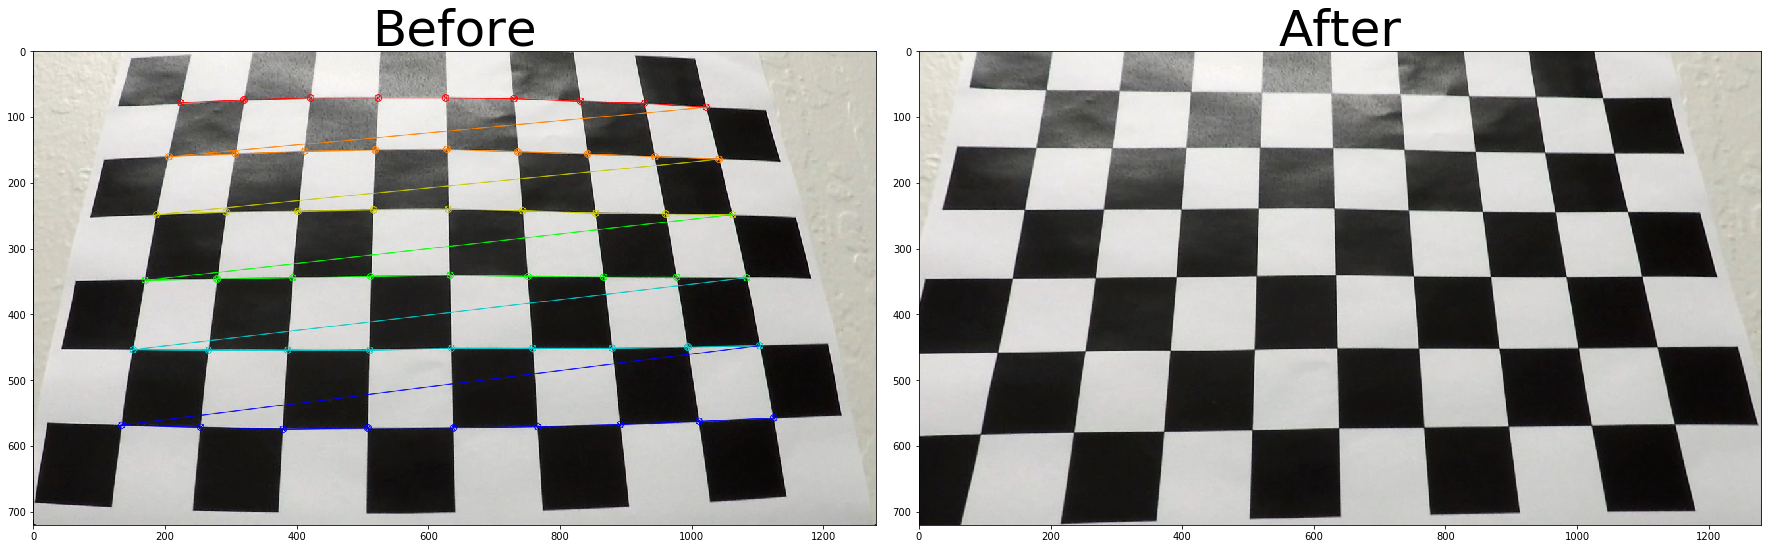

In [7]:
# Exploration of Undistortion
showBeforeVsAfter(drawCorners(sample_image)[3], cv2.undistort(sample_image,matrix,distortion))

### Perspective Transform

In [8]:
def transform_chessboard_perspective(image, matrix, distortion, nx=9, ny=6):
    """
    Undistorts and transforms the perpective of a chessboard image.
    :param image: The chessboard image to undistort and transform
    :param matrix: The camera distortion matrix
    :param distortion: The camera distortion coefficient
    :param nx: The number of horizontal corners to look for on the chessboard
    :param ny: The number of vertical corners to look for on the chessboard
    
    :return transformed_image, perspective_matrix: A perspective 
        transformed image and the perspective matrix
    """

    undistorted_image = cv2.undistort(image,matrix,distortion)
    # Get the chessboard corners
    ret, objp, corners, higlighted_image = drawCorners(undistorted_image, nx, ny)
    transformed_image = None
    perspective_matrix = None
    if ret:
        img_size = (undistorted_image.shape[1], undistorted_image.shape[0])
        # Set the outermost corners of the chessboard as the transform source.
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        offset = 120 # offset for dst points
        # Set destination points that works for most of the sample images.
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
            [img_size[0]-offset, img_size[1]-offset], [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        perspective_matrix = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        transformed_image = cv2.warpPerspective(undistorted_image, perspective_matrix, img_size, flags=cv2.INTER_LINEAR)
        # Return the resulting image and matrix
    return transformed_image, perspective_matrix

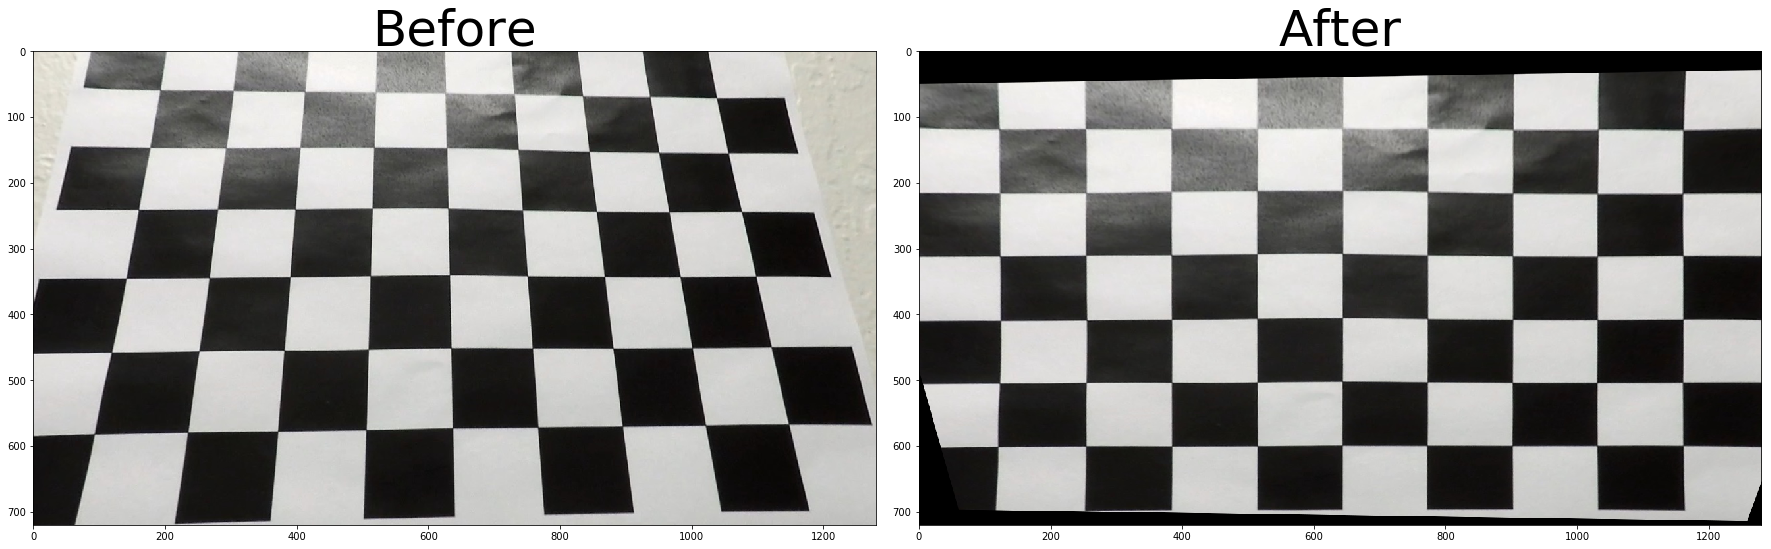

In [9]:
#Exploration
warped_image, perspective_matrix = transform_chessboard_perspective(sample_image,matrix,distortion)
showBeforeVsAfter(cv2.undistort(sample_image,matrix,distortion), warped_image)

### Transform other Image Perspectives

#### We can now extrapolate and use our camera calibration to apply a perspective transform to other images taken by the same camera.

In [10]:
def transform_image(image, camera_matrix, camera_distortion):
    """
    Undistorts and transforms the perpective of a chessboard image.
    :param image: The chessboard image to undistort and transform
    :param matrix: The camera distortion matrix
    :param distortion: The camera distortion coefficient
    :param nx: The number of horizontal corners to look for on the chessboard
    :param ny: The number of vertical corners to look for on the chessboard
    
    :return transformed_image, perspective_matrix: A perspective 
        transformed image and the perspective matrix
    """
    
    # Undistort image
    undistorted_image = cv2.undistort(image,camera_matrix,camera_distortion)
    # Convert to grayscale
    gray = cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1], gray.shape[0])
    # Set the outermost corners of the chessboard as the transform source.
    src = np.float32([[560,475], [726,475], [270,680], [1050,680]])
    offset = 275 # offset for dst points from the top of the image
    # Set destination points that works for most of the sample images.
    dst = np.float32([[270, offset], [1050, offset], [270,680], [1050,680]])
    # Given src and dst points, calculate the perspective transform matrix
    perspective_matrix = cv2.getPerspectiveTransform(src, dst)
    # matrix to be used to undo perspective transform 
    reverse_matrix = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    transformed_image = cv2.warpPerspective(undistorted_image, perspective_matrix, img_size, flags=cv2.INTER_LINEAR)
    # Return the resulting image and matrix
    return reverse_matrix, transformed_image

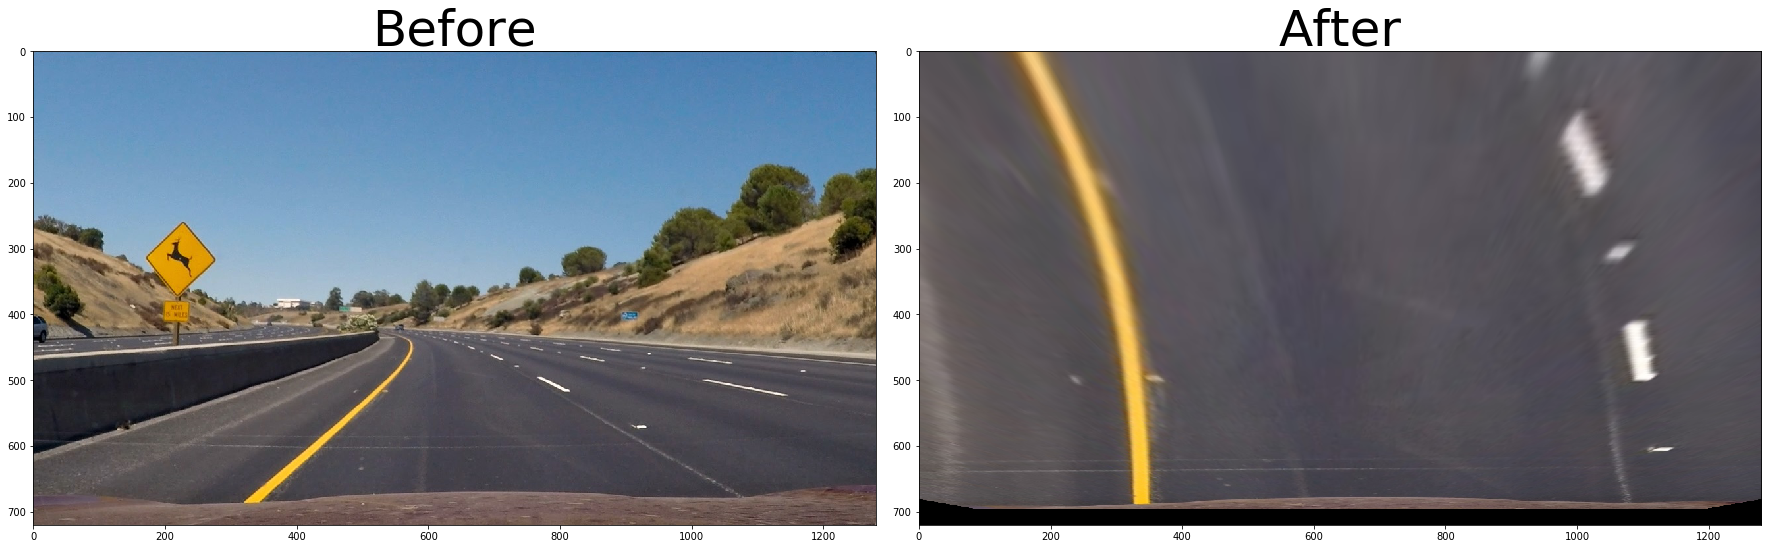

In [11]:
#Exploration
test_image = cv2.imread("test_images/test2.jpg")
reverse_matrix, warped_test_image = transform_image(test_image,matrix,distortion)
showBeforeVsAfter(test_image, warped_test_image)

In [12]:
def abs_sobel(img, orient='x', kernel=3):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    x = 1 if orient == 'x' else 0
    y = 1 if orient == 'y' else 0
    sobel = cv2.Sobel(gray,cv2.CV_64F,x,y,ksize=kernel)
    abs_sobel = np.absolute(sobel)
    return abs_sobel 

def abs_sobel_thresh(img, orient='x', kernel=3,thresh=(0,255)):
    sobel = abs_sobel(img,orient,kernel)
    scaled = np.uint8(255*sobel/np.max(sobel))
    mask = np.zeros_like(scaled)
    mask[(scaled > thresh[0]) & (scaled < thresh[1])] = 1
    return mask

def mag_thresh(img, kernel=3, thresh=(0,255)):
    abs_sobel_x = abs_sobel(img,'x',kernel)
    abs_sobel_y = abs_sobel(img,'y',kernel)
    gradient = np.sqrt(abs_sobel_x**2 + abs_sobel_y**2)
    scaled = np.uint8(255*gradient/np.max(gradient))
    mask = np.zeros_like(scaled)
    mask[(scaled > thresh[0]) & (scaled < thresh[1])] = 1
    return mask

def dir_thresh(img, kernel=3, thresh=(0, np.pi/2)):
    abs_sobel_x = abs_sobel(img,'x',kernel)
    abs_sobel_y = abs_sobel(img,'y',kernel)
    direction = np.arctan2(abs_sobel_y,abs_sobel_x)
    mask = np.zeros_like(direction)
    mask[(direction > thresh[0]) & (direction < thresh[1])] = 1
    return mask

def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls_image = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    s_channel = hls_image[:,:,2]
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def luv_select(img, thresh=(0, 255)):
    # 1) Convert to LUV color space
    luv_image = cv2.cvtColor(img,cv2.COLOR_BGR2LUV)
    l_channel = luv_image[:,:,0]
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(l_channel)
    binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def lab_select(img, thresh=(0, 255)):
    # 1) Convert to LAB color space
    lab_image = cv2.cvtColor(img,cv2.COLOR_BGR2LAB)
    b_channel = lab_image[:,:,2]
    # 2) Apply a threshold to the B channel
    binary_output = np.zeros_like(b_channel)
    binary_output[(b_channel > thresh[0]) & (b_channel <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def warp_binary_image(warped_test_image):
    ksize = 7

    hls_binary = hls_select(warped_test_image, thresh=(170, 255))
    luv_binary = luv_select(warped_test_image, thresh=(195, 255))
    lab_binary = lab_select(warped_test_image, thresh=(155, 200))
    gradx = abs_sobel_thresh(warped_test_image, orient='x', kernel=ksize, thresh=(20,100))
    grady = abs_sobel_thresh(warped_test_image, orient='y', kernel=ksize, thresh=(30,100))
    magnitude = mag_thresh(warped_test_image,kernel=ksize,thresh=(15,100))
    direction = dir_thresh(warped_test_image,kernel=ksize,thresh=(0.0,0.3))

    combined = np.zeros_like(gradx)
    combined[((gradx == 1) & (grady == 1)) | 
             ((magnitude == 1) & (direction == 1)) | 
             ((hls_binary == 1) & (luv_binary == 1)) |
             (lab_binary == 1)] = 1
    return combined

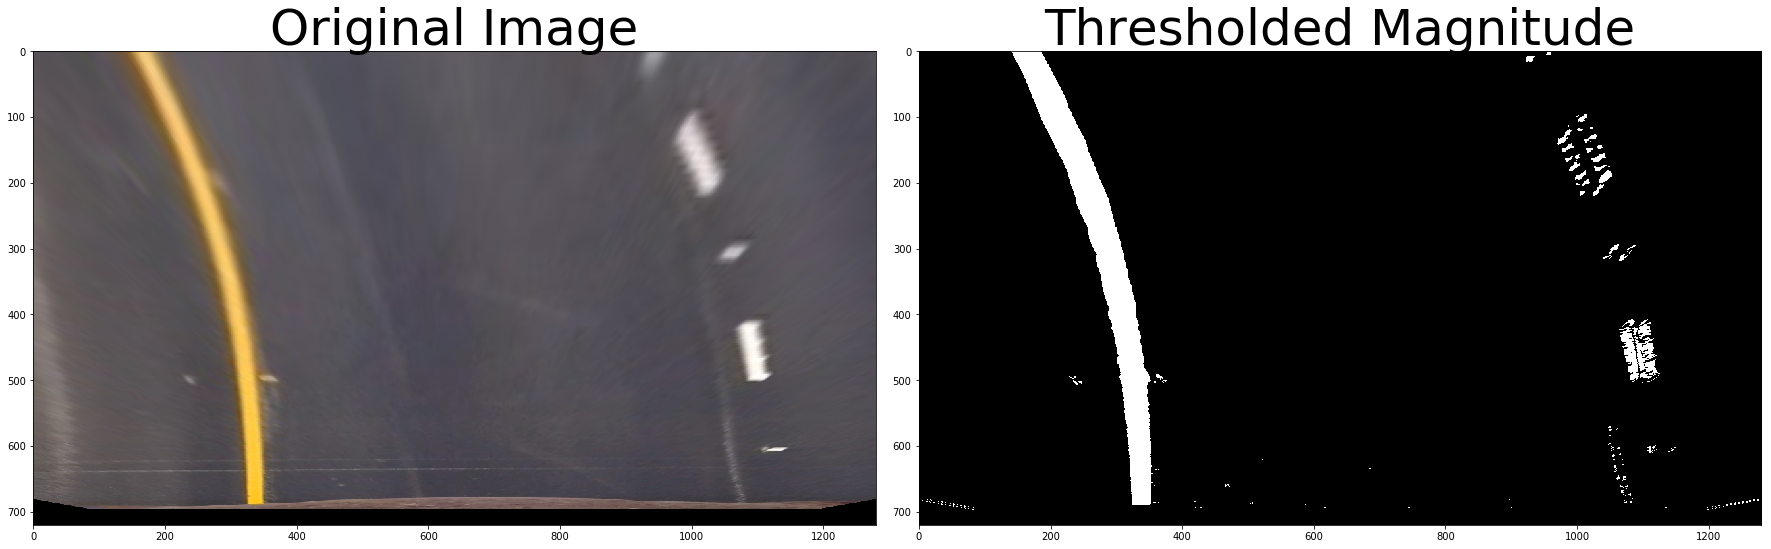

In [13]:
# Exploration

warped_binary_image = warp_binary_image(warped_test_image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(warped_test_image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped_binary_image, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Detect Lane Lines

In [14]:
class Lane():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # is this a left lane?
        self.is_left_lane = False
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients over the last n iterations        
        self.recent_best_fits = []
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [15]:
#Adapted from Udacity lesson on sliding window curve detection.
def detect_lane_curve(warped_binary_image, is_left_lane, analyze=False):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped_binary_image[np.int(warped_binary_image.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped_binary_image, warped_binary_image, warped_binary_image))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    # Get the 'x' with the most lane pixels from left or right of image depending on which lane is being examined
    x_base = np.argmax(histogram[:midpoint]) if is_left_lane else np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped_binary_image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    x_current = x_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    lane_inds = []
    axes = None
    if analyze:
        f, axes = plt.subplots(9, 1, figsize=(6, 9))
        f.tight_layout()

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_binary_image.shape[0] - (window+1)*window_height
        win_y_high = warped_binary_image.shape[0] - window*window_height
        win_x_low = x_current - margin
        win_x_high = x_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_x_low,win_y_low),(win_x_high,win_y_high), (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_x_low) &  (nonzerox < win_x_high)).nonzero()[0]
        # Append these indices to the lists
        lane_inds.append(good_inds)
        if analyze:
            axes[window].hist(nonzerox[good_inds])

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_inds) > minpix:
            x_current = np.int(np.mean(nonzerox[good_inds]))

    # Concatenate the arrays of indices
    lane_inds = np.concatenate(lane_inds)

    # Extract left and right line pixel positions
    x = nonzerox[lane_inds]
    y = nonzeroy[lane_inds]

    # Fit a second order polynomial to the detexted pixel points
    best_fit = np.polyfit(y, x, 2)
    
    return best_fit, x, y

## Guess Lane Curve

In [32]:
# Based on previously detected lane, guess next lane
def guess_new_lane(warped_binary_image, previous_lane):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped_binary_image[np.int(warped_binary_image.shape[0]/2):,:], axis=0)
    # Get middle of lane
    midpoint = np.int(histogram.shape[0]/2)
    # Get the 'x' with the most lane pixels from left or right of image depending on which lane is being examined
    x_base = np.argmax(histogram[:midpoint]) if previous_lane.is_left_lane else np.argmax(histogram[midpoint:]) + midpoint
    # Margin of error for a new lane to be considered to be in a similar position as the previously detected lane
    # A lane marking is 150mm in width which is about 20px in our camera image so we'll give an allowance of +-15px
    # compared to the previous lane
    similar_line_margin = 10
    # Check if new lane center is close to previously detected lane line
    is_similar_lane = (x_base >= (previous_lane.bestx - similar_line_margin) and x_base <= (previous_lane.bestx + similar_line_margin))
    new_lane = Lane()
    previous_lane_max = 5

    if is_similar_lane: # Use the precomputed model of the previous line
        # was the line detected in the this iteration?
        new_lane.detected = False  
        # is this a left lane?
        new_lane.is_left_lane = previous_lane.is_left_lane
        # x values of the last n fits of the line
        new_lane.recent_xfitted = previous_lane.recent_xfitted
        #average x values of the fitted line over the last n iterations
        new_lane.recent_best_fits = previous_lane.recent_best_fits
        new_lane.bestx = previous_lane.bestx
        #polynomial coefficients over the last n iterations
        new_lane.recent_best_fits = previous_lane.recent_best_fits
        #polynomial coefficients averaged over the last n iterations
        new_lane.best_fit = previous_lane.best_fit
    else : # Compute line with new model
        previous_lane_count = min(len(previous_lane.recent_xfitted), previous_lane_max)
        best_fit, x, y = detect_lane_curve(warped_binary_image, previous_lane.is_left_lane)
        # was the line detected in the this iteration?
        new_lane.detected = True  
        # is this a left lane?
        new_lane.is_left_lane = previous_lane.is_left_lane
        # x values of the last n fits of the line
        if previous_lane_count > 0:
            new_lane.recent_xfitted.extend(previous_lane.recent_xfitted[(-1 * previous_lane_count):])
        new_lane.recent_xfitted.append(x)
        recent_xfitted = []
        for xfitted in new_lane.recent_xfitted:
            recent_xfitted.extend(xfitted)
        #average x values of the fitted line over the last n iterations
        new_lane.bestx = np.mean(recent_xfitted)
        #polynomial coefficients over the last n iterations
        if previous_lane_count > 0:
            new_lane.recent_best_fits.extend(previous_lane.recent_best_fits[(-1 * previous_lane_count):])
        new_lane.recent_best_fits.append(best_fit)
        #polynomial coefficients averaged over the last n iterations
        new_lane.best_fit = np.mean(new_lane.recent_best_fits, axis=0)  
        #polynomial coefficients for the most recent fit
        new_lane.current_fit = best_fit
        #x values for detected line pixels
        new_lane.allx = x  
        #y values for detected line pixels
        new_lane.ally = y
    return new_lane

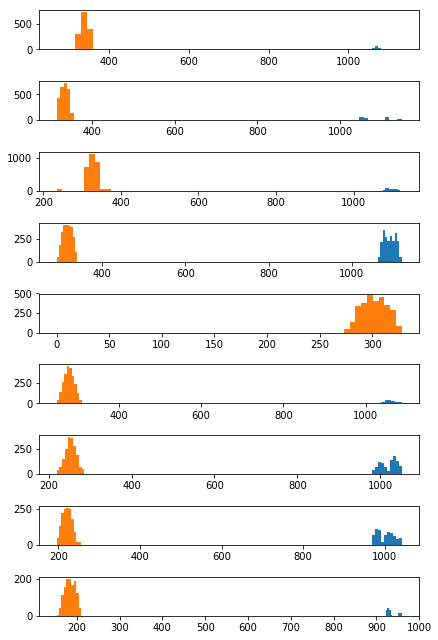

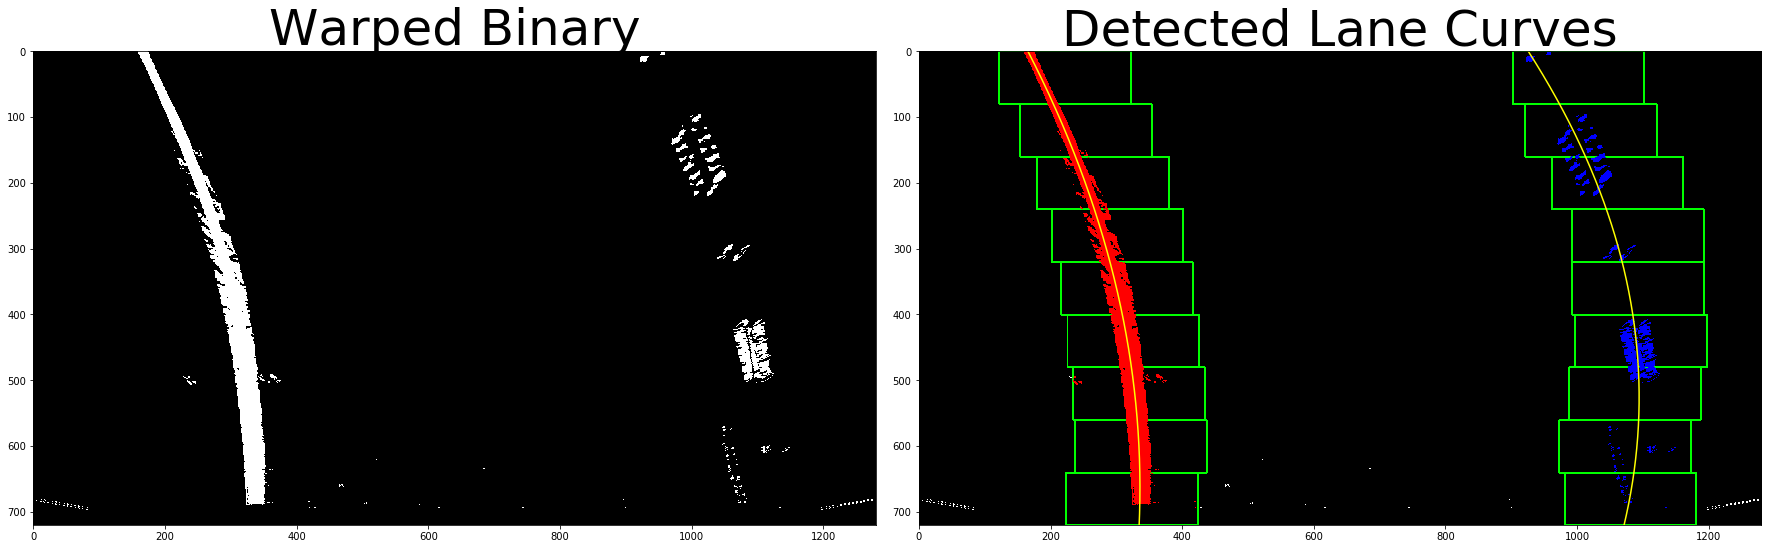

In [15]:
# Exploration
left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img = detect_lane_curve(warped_binary_image,True)
ploty = np.linspace(0, warped_binary_image.shape[0]-1, warped_binary_image.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(warped_binary_image, cmap='gray')
ax1.set_title('Warped Binary', fontsize=50)
ax2.imshow(out_img)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
ax2.set_title('Detected Lane Curves', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [17]:
def fit_detected_lanes(warped_binary_image, left_fit, right_fit, analyze=False):
    nonzero = warped_binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_binary_image.shape[0]-1, warped_binary_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped_binary_image, warped_binary_image, warped_binary_image))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    if analyze:
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit, right_fit, ploty

In [18]:
def get_radius_of_curvature(warped_binary_image, ploty, left_fitx, right_fitx):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient

    leftx = left_fitx[::-1]  # Reverse to match top-to-bottom in y
    rightx = right_fitx[::-1]  # Reverse to match top-to-bottom in y

    # Fit new polynomials to x,y in world space
    img_height = warped_binary_image.shape[0]
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

def get_distance_from_center(warped_binary_image, left_fitx, right_fitx):
    xm_per_pix = 3.7/800 # meters per pixel in x dimension
    camera_center = warped_binary_image.shape[1]/2
    lane_center = np.mean((left_fitx[-1], right_fitx[-1]))
    distance_from_center = (camera_center - lane_center) * xm_per_pix
    return distance_from_center

In [ ]:
# Explore radius of curvature and distance from center of lane
left_curve, right_curve = get_radius_of_curvature(warped_binary_image, ploty, left_fitx, right_fitx)
print(left_curve, 'm', right_curve, 'm')
distance_from_center = get_distance_from_center(warped_binary_image, left_fitx, right_fitx)
print(distance_from_center, 'm')

## Overlay Detected Lanes on Image

In [19]:
def overlay_detected_lines(original_image, warped_binary_image, reverse_matrix, left_fitx, right_fitx, ploty, is_new_model_used=True):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_binary_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, reverse_matrix, (warped_binary_image.shape[1], warped_binary_image.shape[0])) 

    # Combine the result with the original image
    overlayed_image = cv2.cvtColor(cv2.addWeighted(original_image, 1, newwarp, 0.3, 0), cv2.COLOR_BGR2RGB)
    
    left_curve, right_curve = get_radius_of_curvature(warped_binary_image, ploty, left_fitx, right_fitx)
    distance_from_center = get_distance_from_center(warped_binary_image, left_fitx, right_fitx)
    radius_of_curvature_label = 'Radius of curvature: {:.2f}m'.format(np.mean((left_curve,right_curve)))
    off_center_status_label = ('Left of center by: {:.2f}m' if distance_from_center < 0 else 'Right of center by: {:.2f}m').format(
        np.abs(distance_from_center))
    model_used_label = 'Model used: New model' if is_new_model_used else 'Model used: Precomputed'

    overlayed_image = cv2.putText(overlayed_image, radius_of_curvature_label, (20,50), cv2.FONT_HERSHEY_DUPLEX, 1, (255,255,255), 2)
    overlayed_image = cv2.putText(overlayed_image, off_center_status_label, (20,100), cv2.FONT_HERSHEY_DUPLEX, 1, (255,255,255), 2)
    overlayed_image = cv2.putText(overlayed_image, model_used_label, (20,150), cv2.FONT_HERSHEY_DUPLEX, 1, (255,255,255), 2)
    return overlayed_image

# Lane Detection Pipeline

In [20]:
# Calibrate Camera
object_points = [] 
image_points = []

for image_path in glob.glob("camera_cal/*.jpg"):
    image = cv2.imread(image_path)
    ret, objp, corners, higlighted_image = drawCorners(image)
    if ret:
        object_points.append(objp)
        image_points.append(corners)

matrix,distortion = calibrate_camera(image.shape[1::-1],object_points,image_points)

In [30]:
def get_road_lane(warped_binary_image, previous_lane, is_left_lane):
    new_lane = Lane()
    previous_lane_max = 5
    # For the first n frames, use new model to detect the road lanes
    previous_lane_count = len(previous_lane.recent_xfitted)
    if previous_lane_count < previous_lane_max:
        best_fit, x, y = detect_lane_curve(warped_binary_image, is_left_lane)
        # was the line detected in the this iteration?
        new_lane.detected = True  
        # is this a left lane?
        new_lane.is_left_lane = is_left_lane
        # x values of the last n fits of the line
        if previous_lane_count > 0:
            new_lane.recent_xfitted.extend(previous_lane.recent_xfitted[(-1 * previous_lane_count):])
        new_lane.recent_xfitted.append(x)
        recent_xfitted = []
        for xfitted in new_lane.recent_xfitted:
            recent_xfitted.extend(xfitted)
        #average x values of the fitted line over the last n iterations
        new_lane.bestx = np.mean(recent_xfitted)
        #polynomial coefficients over the last n iterations
        if previous_lane_count > 0:
            new_lane.recent_best_fits.extend(previous_lane.recent_best_fits[(-1 * previous_lane_count):])
        new_lane.recent_best_fits.append(best_fit)
        #polynomial coefficients averaged over the last n iterations
        new_lane.best_fit = np.mean(new_lane.recent_best_fits, axis=0)  
        #polynomial coefficients for the most recent fit
        new_lane.current_fit = best_fit
        #x values for detected line pixels
        new_lane.allx = x  
        #y values for detected line pixels
        new_lane.ally = y
    else:
        new_lane = guess_new_lane(warped_binary_image, previous_lane)
    return new_lane

In [25]:
def is_width_reasonable(left_lane, right_lane):
    # A typical lane is 3.7m/800px wide
    expected_width = 800
    error_margin = 45
    lane_width = right_lane.bestx - left_lane.bestx
    # Return first frame as reasonable.
    return (len(left_lane.recent_xfitted) < 2) or (lane_width >= (expected_width - error_margin)) and (lane_width <= (expected_width + error_margin))

# Checks if lane line curves are similar
def is_radius_reasonable(warped_binary_image, ploty, left_fitx, right_fitx):
    # The maximum allowed curve difference between two lane lines.
    maximum_curve_difference = 150
    left_curve, right_curve = get_radius_of_curvature(warped_binary_image, ploty, left_fitx, right_fitx)
    # Return first frame as reasonable.
    return (len(left_lane.recent_xfitted) < 2) or abs(left_curve - right_curve) <= maximum_curve_difference
    
    

In [26]:
def pipeline(image, left_lane, right_lane):
    reverse_matrix, warped_test_image = transform_image(image,matrix,distortion)
    warped_binary_image = warp_binary_image(warped_test_image)
    new_left_lane = get_road_lane(warped_binary_image, left_lane, True)
    new_right_lane = get_road_lane(warped_binary_image, right_lane, False)
    ploty = np.linspace(0, warped_binary_image.shape[0]-1, warped_binary_image.shape[0])
    left_fitx = None
    right_fitx = None
    # Use previous lanes if new lanes are not within reasonable width bounds
    if not is_width_reasonable(new_left_lane, new_right_lane):
        new_left_lane = left_lane
        new_right_lane = right_lane
    else:
        left_fitx = new_left_lane.best_fit[0]*ploty**2 + new_left_lane.best_fit[1]*ploty + new_left_lane.best_fit[2]
        right_fitx = new_right_lane.best_fit[0]*ploty**2 + new_right_lane.best_fit[1]*ploty + new_right_lane.best_fit[2]
        # Use previous lanes if new lanes are not within reasonable radius bounds
        if not is_radius_reasonable(warped_binary_image, ploty, left_fitx, right_fitx):
            new_left_lane = left_lane
            new_right_lane = right_lane
        
    left_fitx = new_left_lane.best_fit[0]*ploty**2 + new_left_lane.best_fit[1]*ploty + new_left_lane.best_fit[2]
    right_fitx = new_right_lane.best_fit[0]*ploty**2 + new_right_lane.best_fit[1]*ploty + new_right_lane.best_fit[2]
    
    # Check if line radius of curvature is reasonable
    
    is_new_model_used = new_left_lane.detected and new_right_lane.detected
    image_with_detected_lanes = overlay_detected_lines(image, warped_binary_image, reverse_matrix, left_fitx, 
                                                       right_fitx, ploty, is_new_model_used)
    return new_left_lane, new_right_lane, cv2.cvtColor(image_with_detected_lanes, cv2.COLOR_BGR2RGB)

In [33]:
project_video_output = 'output_videos/project.mp4'
clip1 = VideoFileClip("project_video.mp4")
left_lane = Lane()
right_lane = Lane()
frames = []
for frame in clip1.iter_frames():
    left_lane, right_lane, image = pipeline(frame, left_lane, right_lane)
    frames.append(image)
image_sequence = ImageSequenceClip(frames, fps=clip1.fps)
%time image_sequence.write_videofile(project_video_output, fps=clip1.fps)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))

[MoviePy] >>>> Building video output_videos/project.mp4
[MoviePy] Writing video output_videos/project.mp4


100%|██████████| 1260/1260 [01:21<00:00, 15.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project.mp4 

CPU times: user 3.45 s, sys: 13.1 s, total: 16.6 s
Wall time: 1min 24s


In [98]:
challenge_video_output = 'output_videos/challenge_new.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
left_lane = Lane()
right_lane = Lane()
frames = []
for frame in clip1.iter_frames():
    left_lane, right_lane, image = pipeline(frame, left_lane, right_lane)
    frames.append(image)
image_sequence = ImageSequenceClip(frames, fps=clip1.fps)
%time image_sequence.write_videofile(challenge_video_output, fps=clip1.fps)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_video_output))

[MoviePy] >>>> Building video output_videos/challenge_new.mp4
[MoviePy] Writing video output_videos/challenge_new.mp4


100%|██████████| 485/485 [00:25<00:00, 19.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_new.mp4 

CPU times: user 863 ms, sys: 924 ms, total: 1.79 s
Wall time: 27.7 s
